Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits

# Загрузка данных
digits = load_digits()

# Получение массива наблюдений (X) и массива истинных меток классов (y)
X = digits.data
y = digits.target

# Вывод размерности массивов
print(f"Размерность массива наблюдений (X): {X.shape}")
print(f"Размерность массива истинных меток классов (y): {y.shape}")

Размерность массива наблюдений (X): (1797, 64)
Размерность массива истинных меток классов (y): (1797,)


Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

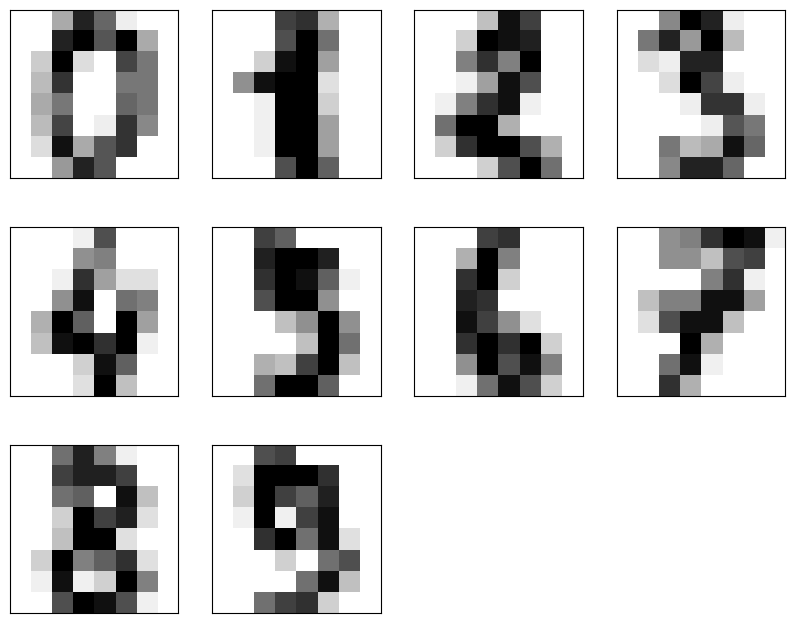

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Выберем первые 10 картинок
images = X[:10, :].reshape(-1, 8, 8)  # Развернем строки обратно в изображения 8x8

# Инвертируем цвета (черный фон, белые цифры)
images = 16 - images

# Создадим сетку 3x4 для отображения первых 10 картинок
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i], cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])


plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [3]:
from sklearn.cluster import AgglomerativeClustering, KMeans

# Иерархическая кластеризация
hierarchical_clustering = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical_clustering.fit_predict(X)

# KMeans
kmeans = KMeans(n_clusters=10, n_init=100)
kmeans_labels = kmeans.fit_predict(X)

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

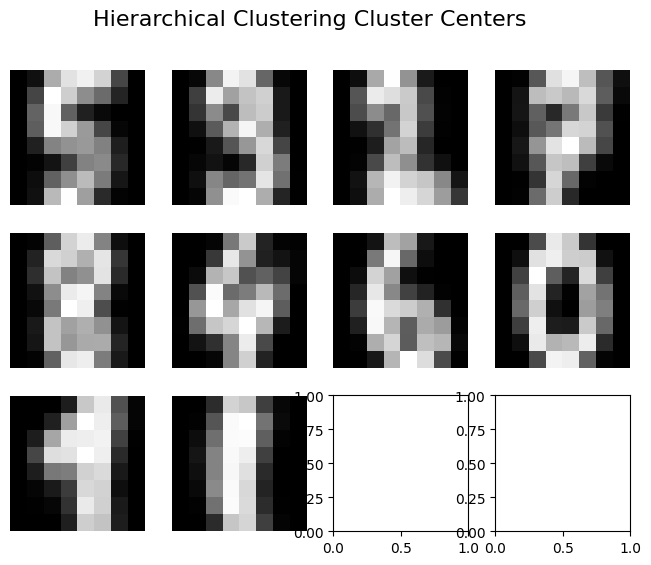

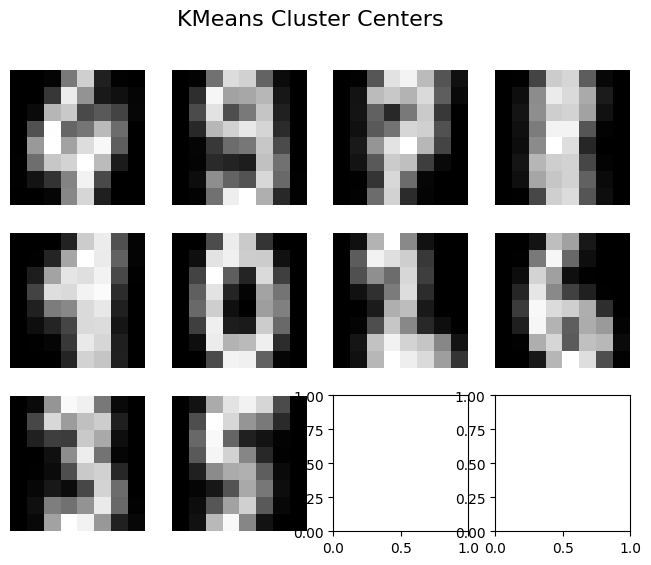

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для визуализации центров кластеров
def plot_cluster_centers(cluster_centers, title):
    fig, ax = plt.subplots(3, 4, figsize=(8, 6))
    plt.gray()

    for i in range(10):
        center_image = cluster_centers[i].reshape(8, 8)
        ax[i // 4, i % 4].imshow(center_image, cmap='gray')
        ax[i // 4, i % 4].axis('off')

    plt.suptitle(title, size=16)
    plt.show()

# Визуализация центров кластеров для иерархической кластеризации
hierarchical_cluster_centers = np.array([X[hierarchical_labels == i].mean(axis=0) for i in range(10)])
plot_cluster_centers(hierarchical_cluster_centers, 'Hierarchical Clustering Cluster Centers')

# Визуализация центров кластеров для KMeans
kmeans_cluster_centers = kmeans.cluster_centers_
plot_cluster_centers(kmeans_cluster_centers, 'KMeans Cluster Centers')


В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

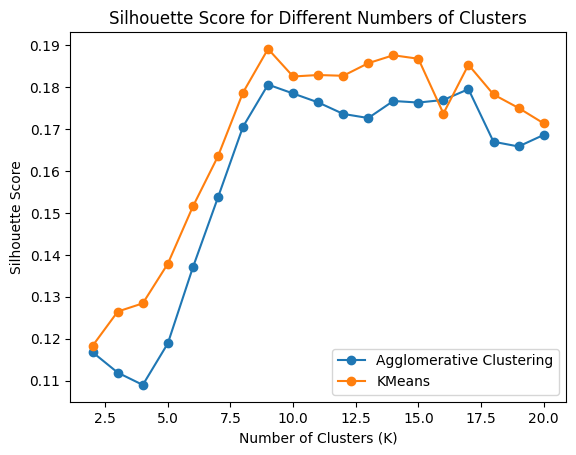

In [7]:
# Создаем список для сохранения значений силуэта
silhouette_scores_hierarchical = []
silhouette_scores_kmeans = []

# Диапазон числа кластеров от 2 до 20
k_values = range(2, 21)

# Итерация по числу кластеров
for k in k_values:
    # Иерархическая кластеризация
    hierarchical_clustering = AgglomerativeClustering(n_clusters=k)
    hierarchical_labels = hierarchical_clustering.fit_predict(X)
    silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
    silhouette_scores_hierarchical.append(silhouette_hierarchical)

    # KMeans
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans_labels = kmeans.fit_predict(X)
    silhouette_kmeans = silhouette_score(X, kmeans_labels)
    silhouette_scores_kmeans.append(silhouette_kmeans)

# Визуализация результатов
plt.plot(k_values, silhouette_scores_hierarchical, label='Agglomerative Clustering', marker='o')
plt.plot(k_values, silhouette_scores_kmeans, label='KMeans', marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.legend(loc='best')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

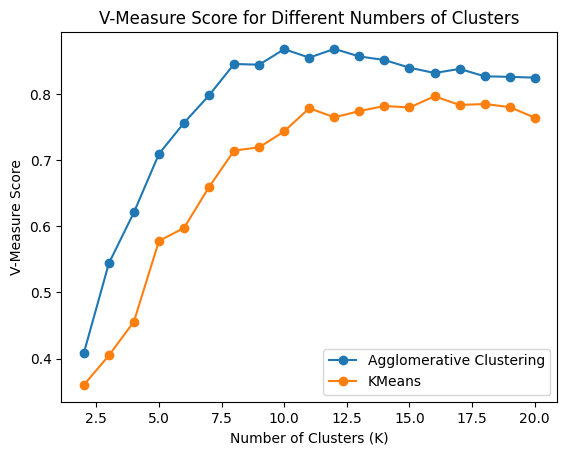

In [11]:
#Оценка качества кластеризации
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import v_measure_score

#Создаем пустые списки для сохранения значений V-меры
v_measure_scores_hierarchical = []
v_measure_scores_kmeans = []

# Задаем диапазон числа кластеров от 2 до 20
k_values = range(2, 21)

# Итерация по числу кластеров
for k in k_values:
    # Иерархическая кластеризация
    hierarchical_clustering = AgglomerativeClustering(n_clusters=k)
    hierarchical_labels = hierarchical_clustering.fit_predict(X)
    v_measure_hierarchical = v_measure_score(y, hierarchical_labels)
    v_measure_scores_hierarchical.append(v_measure_hierarchical)

    # KMeans
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans_labels = kmeans.fit_predict(X)
    v_measure_kmeans = v_measure_score(y, kmeans_labels)
    v_measure_scores_kmeans.append(v_measure_kmeans)

# Визуализация результатов
plt.plot(k_values, v_measure_scores_hierarchical, label='Agglomerative Clustering', marker='o')
plt.plot(k_values, v_measure_scores_kmeans, label='KMeans', marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('V-Measure Score')
plt.legend(loc='best')
plt.title('V-Measure Score for Different Numbers of Clusters')
plt.show()




# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, v_measure_score

# Число кластеров
n_clusters = 10

# Список числа новых признаков
n_components_list = [2, 5, 10, 20]

# Списки для сохранения результатов
silhouette_scores_svd = []
v_measure_scores_svd = []

for n_components in n_components_list:
    # Сингулярное разложение
    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(X)

    # Иерархическая кластеризация
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical_clustering.fit_predict(X_svd)
    silhouette_hierarchical = silhouette_score(X_svd, hierarchical_labels)
    v_measure_hierarchical = v_measure_score(y, hierarchical_labels)

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init=100)
    kmeans_labels = kmeans.fit_predict(X_svd)
    silhouette_kmeans = silhouette_score(X_svd, kmeans_labels)
    v_measure_kmeans = v_measure_score(y, kmeans_labels)

    # Сохранение результатов
    silhouette_scores_svd.append((silhouette_hierarchical, silhouette_kmeans))
    v_measure_scores_svd.append((v_measure_hierarchical, v_measure_kmeans))

# Вывод результатов
for i, n_components in enumerate(n_components_list):
    print(f"Number of components: {n_components}")
    print(f"Silhouette Score (Hierarchical): {silhouette_scores_svd[i][0]}")
    print(f"Silhouette Score (KMeans): {silhouette_scores_svd[i][1]}")
    print(f"V-Measure Score (Hierarchical): {v_measure_scores_svd[i][0]}")
    print(f"V-Measure Score (KMeans): {v_measure_scores_svd[i][1]}")
    print("------")


Number of components: 2
Silhouette Score (Hierarchical): 0.28081699408821464
Silhouette Score (KMeans): 0.34917952644733397
V-Measure Score (Hierarchical): 0.33371899039489245
V-Measure Score (KMeans): 0.34814856857015225
------
Number of components: 5
Silhouette Score (Hierarchical): 0.2727411095555097
Silhouette Score (KMeans): 0.3122113391219008
V-Measure Score (Hierarchical): 0.6756036446423491
V-Measure Score (KMeans): 0.6339501016986269
------
Number of components: 10
Silhouette Score (Hierarchical): 0.25071140952513804
Silhouette Score (KMeans): 0.2631476927930373
V-Measure Score (Hierarchical): 0.8259753348813226
V-Measure Score (KMeans): 0.7206682555404014
------
Number of components: 20
Silhouette Score (Hierarchical): 0.19713372651881292
Silhouette Score (KMeans): 0.21252448421277748
V-Measure Score (Hierarchical): 0.8143882689038883
V-Measure Score (KMeans): 0.740234463405208
------


# Вывод:

# При увеличении числа новых признаков от 2 до 20, Silhouette Score уменьшается.

# Это может быть связано с тем, что в пространстве меньшей размерности становится сложнее сохранить хороший коэффициент силуэта.

# V-Measure Score,увеличивается с увеличением числа новых признаков, но лучший результат для V-Measure Score достигается при 10 новых признаках.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

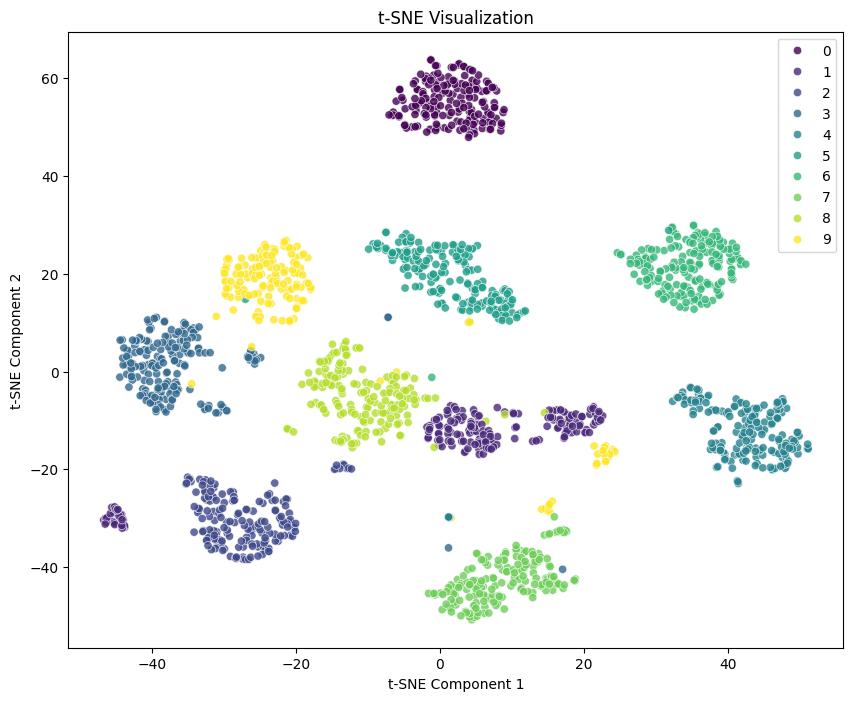

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns

# Создаем объект tSNE с 2 компонентами
tsne = TSNE(n_components=2, random_state=42)

# Преобразуем данные
X_tsne = tsne.fit_transform(X)

# Визуализация данных в виде точечной диаграммы
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [16]:
# Число кластеров
n_clusters = 10

# Иерархическая кластеризация
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels_tsne = hierarchical_clustering.fit_predict(X_tsne)

# KMeans
kmeans_tsne = KMeans(n_clusters=n_clusters, n_init=100)
kmeans_labels_tsne = kmeans_tsne.fit_predict(X_tsne)

# Силуэт и V-мера для иерархической кластеризации
silhouette_hierarchical_tsne = silhouette_score(X_tsne, hierarchical_labels_tsne)
v_measure_hierarchical_tsne = v_measure_score(y, hierarchical_labels_tsne)

# Силуэт и V-мера для KMeans
silhouette_kmeans_tsne = silhouette_score(X_tsne, kmeans_labels_tsne)
v_measure_kmeans_tsne = v_measure_score(y, kmeans_labels_tsne)

# Вывод результатов
print("tSNE-transformed data:")
print(f"Silhouette Score (Hierarchical): {silhouette_hierarchical_tsne}")
print(f"V-Measure Score (Hierarchical): {v_measure_hierarchical_tsne}")
print("------")
print(f"Silhouette Score (KMeans): {silhouette_kmeans_tsne}")
print(f"V-Measure Score (KMeans): {v_measure_kmeans_tsne}")


tSNE-transformed data:
Silhouette Score (Hierarchical): 0.6388839483261108
V-Measure Score (Hierarchical): 0.911056555346593
------
Silhouette Score (KMeans): 0.6419637799263
V-Measure Score (KMeans): 0.9116334462095017


# *Оба метода кластеризации с tSNE, показывают улучшение в силуэте и V-мере по сравнению с исходными данными.*

Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

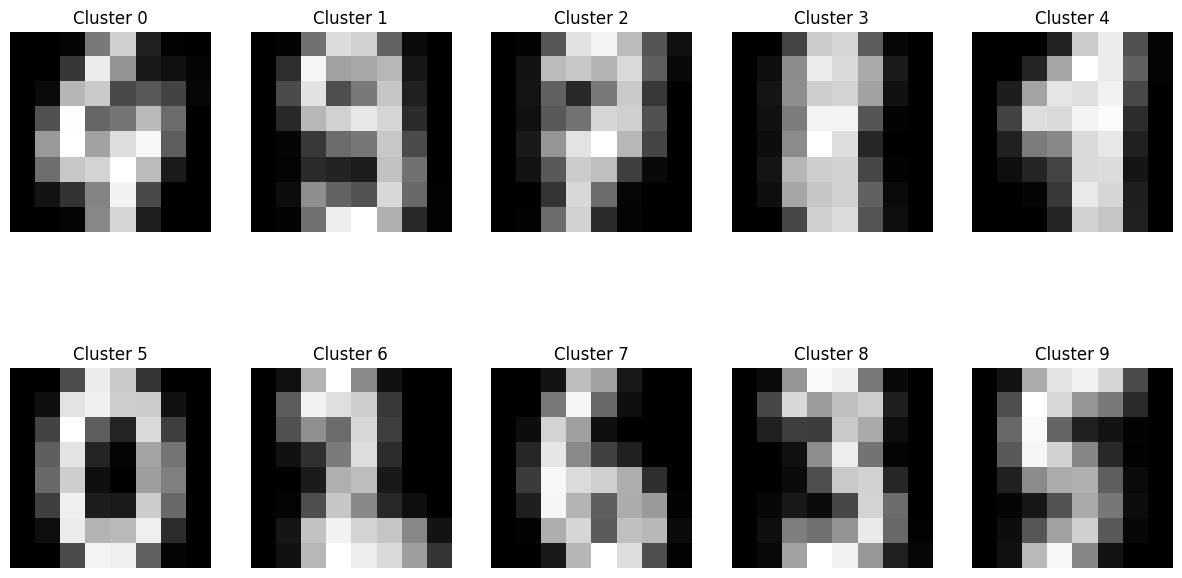

In [28]:
# Визуализация центров кластеров для лучшего разбиения (в терминах силуэта или V-меры)
def visualize_cluster_centers_alt(best_centers, n_clusters):
    plt.figure(figsize=(15, 8))
    for cluster in range(n_clusters):
        plt.subplot(2, n_clusters // 2, cluster + 1)
        plt.title(f'Cluster {cluster}')
        plt.imshow(best_centers[cluster].reshape(8, 8), cmap='gray')  # Показываем центр кластера как изображение
        plt.axis('off')
    plt.show()

# Визуализация центров кластеров
visualize_cluster_centers_alt(best_centers, n_clusters)


# Вывод: каждому кластеру соответсвует 1 цифра

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

**Иерархическая кластеризация показала более высокий силуэт для некоторых конфигураций, но алгоритм K-средних достиг более высокой V-меры для других.**

**Влияние снижения размерности:**

**Снижение размерности признакового пространства с использованием метода сингулярного разложения (SVD) позволило улучшить качество кластеризации по метрикам силуэта и V-меры.При уменьшении числа признаков до 10, V-мера для обоих методов улучшилась.**
